# 2D circle perimeter estimation using neural network
This is a simple notebook to demonstrate basic principles of neural network design and traning with highly imbalanced training data. The problem is to find that does a point in (x, y) space belong to circle perimeter line or not. The solution is a classification model that classifies the points to circle perimeter class (class 1) or background (class 0).

In a principle this is similar to many real world problem solving, where neural network is used to perform classification of a high-dimensional data. This problem is also impossible for neural network to solve analytically (i.e. by learning the equations used to generate data classes) because the used multilayer perceptron has no capabilities to calculate exponent or square root, so the solution will be piecewise approximation like in more complex cases. 

(c) Mikko Kursula 2019. MIT License. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam

## Get input data and define the training target

In [2]:
def define_dataset(n_pts):
    """
    Get random numbers in the [-1, 1] range, arrange those to x, y coordinate 
    pairs and define the labels according to the coordinate location. Points 
    located on a (0, 0) centered circle perimeter line within small tolerance 
    will be labeled 1. All other points will be labeled 0. 
    Total n_pts points will be defined. 
    """
    # Circle parameters
    radius = 0.7
    tolerance = 0.015
    
    # Define data
    data = np.random.rand(n_pts, 2) * 2 - 1

    # Define labeling
    radius_min = radius - tolerance
    radius_max = radius + tolerance
    radiuses = np.sqrt(data[:, 0] ** 2 + data[:, 1] ** 2)
    targets = []
    for radius in radiuses:
        if radius > radius_min and radius < radius_max:
            targets.append(1)
        else:
            targets.append(0)
    targets = np.array(targets)
    return data, targets
    
input_data, target = define_dataset(n_pts=10000)

## Visualize the data

In [3]:
def scatter_plot(input_data, data_class, figsize=(14, 11), cmap='bwr'):
    """
    Plot all the points and color those according to the classifications. 
    The input_data must be numpy array with dimensions (samples, 2). The data_class must be numpy 
    array with dimension (samples) and the indexing must match to the input_data. 
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_facecolor((0, 0, 0))
    plt.scatter(input_data[:, 0], input_data[:, 1], c=data_class, alpha=1, s=10, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

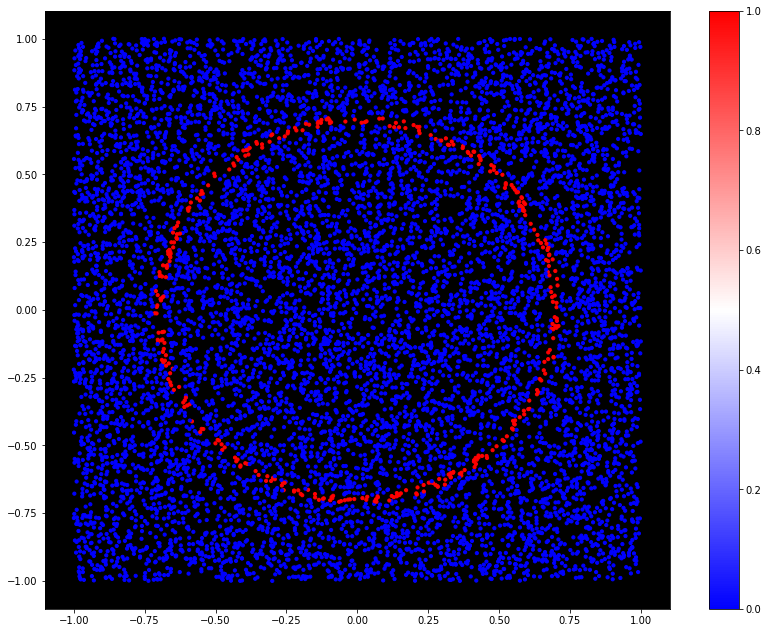

In [4]:
scatter_plot(input_data, target)

## Check class balance

In [5]:
n_neg = np.sum(target == 0)
n_pos = np.sum(target == 1)
print('Class 0 samples : {}'.format(n_neg))
print('Class 1 samples : {}'.format(n_pos))
print('Zero/one class ratio : {:.2f}'.format(n_neg / n_pos))

Class 0 samples : 9642
Class 1 samples : 358
Zero/one class ratio : 26.93


# Neural network model 

In [6]:
def get_model():
    inputs = Input(shape=(2,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [7]:
batch_size = 128
epochs = 20
pos_class_weight = 30
neg_class_weight = 1

class_weights = {0 : neg_class_weight, 1: pos_class_weight}
history = model.fit(x=input_data, y=target, batch_size=batch_size, epochs=epochs, 
                    verbose=2, validation_split=0.3, class_weight=class_weights)

Train on 7000 samples, validate on 3000 samples
Epoch 1/20
 - 1s - loss: 1.4093 - acc: 0.4831 - val_loss: 1.4153 - val_acc: 0.4113
Epoch 2/20
 - 0s - loss: 1.4042 - acc: 0.4093 - val_loss: 1.4146 - val_acc: 0.3923
Epoch 3/20
 - 0s - loss: 1.3993 - acc: 0.3967 - val_loss: 1.4087 - val_acc: 0.2803
Epoch 4/20
 - 0s - loss: 1.3959 - acc: 0.4077 - val_loss: 1.4089 - val_acc: 0.3470
Epoch 5/20
 - 0s - loss: 1.3858 - acc: 0.3371 - val_loss: 1.3984 - val_acc: 0.4570
Epoch 6/20
 - 0s - loss: 1.3743 - acc: 0.5644 - val_loss: 1.3874 - val_acc: 0.3613
Epoch 7/20
 - 0s - loss: 1.3538 - acc: 0.5167 - val_loss: 1.3625 - val_acc: 0.4090
Epoch 8/20
 - 0s - loss: 1.3171 - acc: 0.5141 - val_loss: 1.3151 - val_acc: 0.6120
Epoch 9/20
 - 0s - loss: 1.2420 - acc: 0.6280 - val_loss: 1.1910 - val_acc: 0.6413
Epoch 10/20
 - 0s - loss: 1.1085 - acc: 0.6906 - val_loss: 1.0234 - val_acc: 0.6723
Epoch 11/20
 - 0s - loss: 0.9351 - acc: 0.7073 - val_loss: 0.8280 - val_acc: 0.7647
Epoch 12/20
 - 0s - loss: 0.7671 - ac

## Plot training results

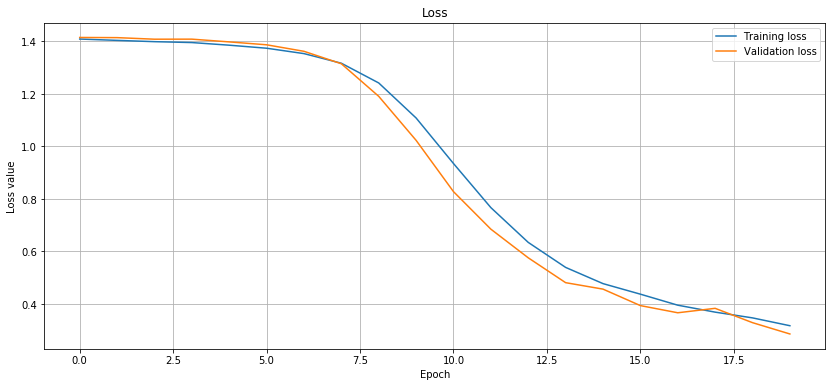

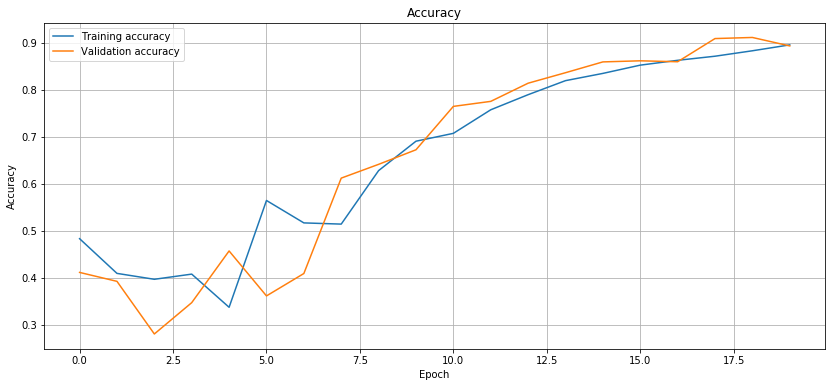

In [8]:
def plot_history(history, figsize=(14, 6)):
    # Loss
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.legend()
    plt.grid()
    plt.show()

    # Accuracy
    plt.figure(figsize=figsize)
    plt.plot(history.history['acc'], label='Training accuracy')
    plt.plot(history.history['val_acc'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_history(history)

## Testing
This demonstrates simple classification quality evaluation and the typical pitfalls in using common metrics such as accuracy. 

Compare also the prediction scatter plots to the input dataset plot done earlier to visualize how the decision boundaries differ from the original data boundaries. 


In [13]:
# Get new data for testing 
test_data, test_target = define_dataset(10000)

# Make predictions using the trained model 
predictions = model.predict(x=test_data, verbose=1, batch_size=128).flatten()

10000/10000 [==============================] - 0s 5us/step


In [14]:
def evaluate_results(predictions, targets):
    """
    Calculate the most basic model performance metrics. 
    """
    class_threshold = 0.5 
    predictions = (predictions > class_threshold) * 1
    true_neg = 0
    false_neg = 0
    true_pos = 0
    false_pos = 0
    
    for idx, prediction in enumerate(predictions):
        true = targets[idx]
        if true == 1 and prediction == 1: 
            true_pos += 1
            
        elif true == 0 and prediction == 1: 
            false_pos += 1
        
        elif true == 0 and prediction == 0: 
            true_neg += 1
        
        elif true == 1 and prediction == 0: 
            false_neg += 1

    # Calculate scores
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    accuracy = (true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)    
    matthews_corr = (true_pos * true_neg - false_pos * false_neg) / (
                    (true_pos + false_pos) * (true_pos + false_neg) *
                    (true_neg + false_pos) * (true_neg + false_neg)) ** 0.5 
    f1_score = 2 * precision * recall / (precision + recall)

    print('Results')
    print('True class 1 \t {}'.format(true_pos))
    print('False class 1 \t {}'.format(false_pos))
    print('True class 0 \t {}'.format(true_neg))
    print('False class 0 \t {}'.format(false_neg))
    print('')
    print('Metrics:')
    print('Accuracy \t {:.3f}'.format(accuracy))
    print('Recall \t\t {:.3f}'.format(recall))
    print('Precision  \t {:.3f}'.format(precision))
    print('Matthews corr \t {:.3f}'.format(matthews_corr))
    print('F-1 score \t {:.3f}'.format(f1_score))
    
    
evaluate_results(predictions, test_target)

Results
True class 1 	 339
False class 1 	 1106
True class 0 	 8555
False class 0 	 0

Metrics:
Accuracy 	 0.889
Recall 		 1.000
Precision  	 0.235
Matthews corr 	 0.456
F-1 score 	 0.380


From the above results varius things can be seen: 
- The accuracy result looks quite good and the model got about 88% of predictions correct. However, this can be very misleading when the data classes are not balanced. 
- The recall is perfect 1.0 meaning that the model was able to find and classify all class 1 points correctly. 
- The huge downside is that there are lot of false class 1 results which makes the precision very poor. For every correct result there are four false results in the class 1 predictions. 
- Matthews correlation coefficient gives pretty poor score for the predictions. It takes the class balance into account, so it gives more truthful view than e.g. accuracy. The Matthews correlation coefficient can range from 1 (best) to -1 (worst). Result 0 means purely random classification. 
- F-1 score is another popular metric and also it gives poor result. F-1 score range is from 1 (best) to 0 (worst). 

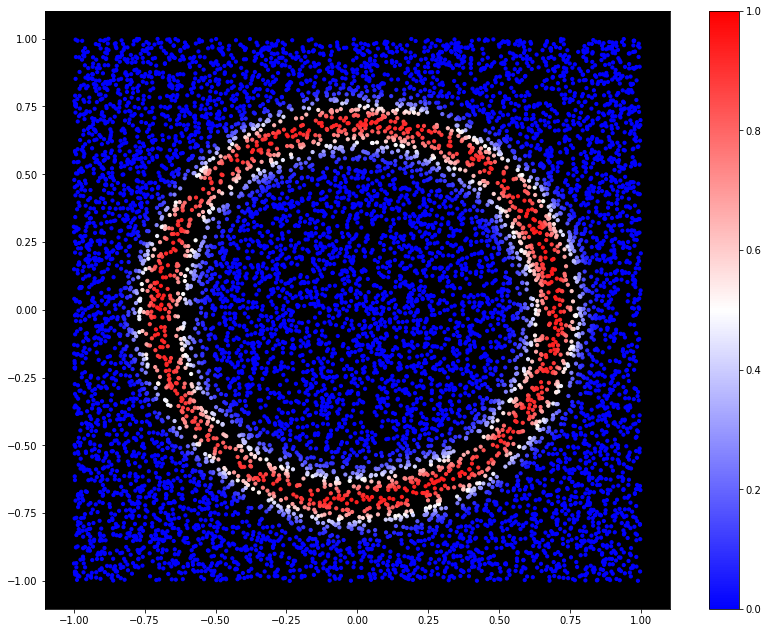

In [11]:
# Plot the prediction results 
scatter_plot(test_data, predictions)

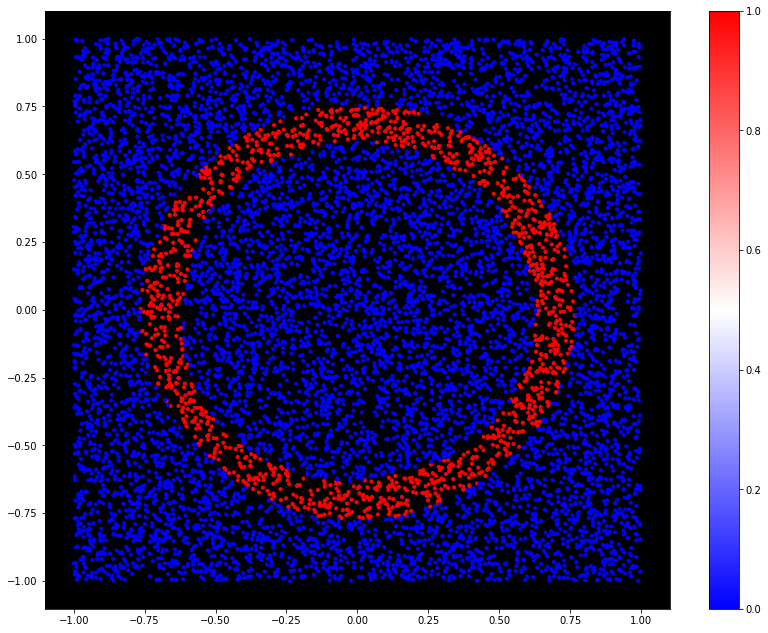

In [12]:
# Make the same plot with binary values using threshold 0.5. 
scatter_plot(test_data, (predictions > 0.5) * 1)

### Summary
With the default parameters the model can approximate the target, but the decision boundaries are large and it causes very large number of false positives. Only about 1/5th of the predicted positives are true positives.  
Try playing with the parameters and see how it affects the results. For example, the following will have impact to the results: 
- Number of training data samples. 
- Radius tolerance used in data labeling.
- Shape of the labeling function (try e.g. different radius, different function, etc). 
- Model architecture, layer sizes, number of layers, activation functions, etc. 
- Training class weights.
- Training epochs, batch sizes and learning rate. 